## Initial checking

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn import ensemble, preprocessing, tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve

In [2]:
df = pd.read_excel('/Users/aline/Titanic/titanic3.xls')
orig_df = df

In [3]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [ ]:
import pandas_profiling
profile = df.profile_report(title='Titanic Profiling Report', progress_bar=True)
profile.to_widgets()
profile

In [ ]:
# save profile to html
profile.to_file("/Users/aline/Titanic/profile.html")

In [4]:
df.shape

(1309, 14)

In [5]:
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [6]:
# any missing values?
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [7]:
df.isnull().sum(axis=1).loc[:10]

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

Let’s look at some of the rows with missing data

In [9]:
mask = df.isnull().any(axis=1)
mask.head() #rows

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [10]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [11]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [12]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

## Create Features

Let's drop columns that leak information

In [13]:
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [14]:
df = df.drop(
    columns=[
        "name", 
        "ticket", 
        "home.dest", 
        "boat", 
        "body", 
        "cabin",
    ]
)

We need to create dummy columns from string columns. This will create new columns for sex and embarked. Pandas has a convenient get_dummies function for that

In [15]:
df = pd.get_dummies(df)

In [16]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

We can add a drop_first=True parameter to the get_dummies call:

In [17]:
df = pd.get_dummies(df, drop_first=True)

In [18]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

Create a DataFrame (X) with the features and a series (y) with the labels. We could also use numpy arrays, but then we don’t have column names:

In [19]:
y = df.survived
X = df.drop(columns="survived")

## Sample Data

In [20]:
# train test split
# 30% for testing 
# why random state is 42 is a good question for intreviews ;)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Impute Data

In [21]:
# I've never tested the IterativeImputer, let's check it
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

In [22]:
num_cols = [
    "pclass", 
    "age", 
    "sibsp", 
    "parch", 
    "fare", 
    "sex_female",
]

In [23]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X_train[num_cols])
X_train.loc[:, num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

If we wanted to impute with the median, we can use pandas to do that:

In [24]:
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

## Normalize Data

Standardize the data for the preprocessing

In [25]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

## Refactor

Here are two functions. One for general cleaning, and another for dividing up into a training and testing set and to perform mutations that need to happen differently on those sets

In [26]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [27]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:,num_cols] = fi.transform(X_test[num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])
        return X_train, X_test, y_train, y_test

        

In [28]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

## Baseline Model

Creating a baseline model that does something really simple can give us something to compare our model to. Note that using the default .score result gives us the accuracy which can be misleading. A problem where a positive case is 1 in 10,000 can easily get over 99% accuracy by always predicting negative.

In [29]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier(strategy="uniform", random_state=42)
bm.fit(X_train, y_train)
bm.score(X_test, y_test) # accuracy

0.48346055979643765

In [30]:
from sklearn.metrics import precision_score
precision_score(y_test, bm.predict(X_test))

0.413265306122449

## Various Families

This code tries a variety of algorithm families. The “No Free Lunch” theorem states that no algorithm performs well on all data. However, for some finite set of data, there may be an algorithm that does well on that set. (A popular choice for structured learning these days is a tree-boosted algorithm such as XGBoost.)

Here we use a few different families and compare the AUC score and standard deviation using k-fold cross-validation. An algorithm that has a slightly smaller average score but tighter standard deviation might be a better choice.

Because we are using k-fold cross-validation, we will feed the model all of X and y:

In [34]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost

for model in [  # the code in the book passes classes, I pass instances of classes, coz you can set params
    DummyClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier(),
    xgboost.XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    ]:

    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    score = model_selection.cross_val_score(model, X, y, scoring="roc_auc", cv = kfold)
    name = type(model).__name__
    print(
        f"{name:22} AUC: " 
        f"{score.mean():.3f} STD: {score.std():.2f}"
    )

DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.840 STD: 0.04
DecisionTreeClassifier AUC: 0.761 STD: 0.03
KNeighborsClassifier   AUC: 0.830 STD: 0.02
GaussianNB             AUC: 0.811 STD: 0.05
SVC                    AUC: 0.838 STD: 0.03
RandomForestClassifier AUC: 0.848 STD: 0.02
XGBClassifier          AUC: 0.854 STD: 0.02


## Stacking

In [36]:
from mlxtend.classifier import StackingClassifier
clfs = [
    x()
    for x in [
        LogisticRegression, 
        DecisionTreeClassifier, 
        KNeighborsClassifier, 
        GaussianNB, 
        SVC, 
        RandomForestClassifier,
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(
    n_splits=10,
    random_state=42,
    shuffle=True
)
s = model_selection.cross_val_score(
    stack, X, y, scoring = "roc_auc", cv = kfold
)
print(
    f"{stack.__class__.__name__} "
    f"AUC: {s.mean():.3f} STD: {s.std():.2f}"
)

StackingClassifier AUC: 0.808 STD: 0.04


## Create Model

I’m going to use a random forest classifier to create a model. It is a flexible model that tends to give decent out-of-the-box results. Remember to train it (calling .fit) with the training data from the data that we split earlier into a training and testing set:

In [38]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model

Now that we have a model, we can use the test data to see how well the model generalizes to data that it hasn’t seen before. The .score method of a classifier returns the average of the prediction accuracy. We want to make sure that we call the .score method with the test data (presumably it should perform better with the training data):

In [39]:
rf.score(X_test, y_test)

0.7837150127226463

We can also look at other metrics, such as precision:

In [41]:
precision_score(y_test, rf.predict(X_test))

0.7916666666666666

A nice benefit of tree-based models is that you can inspect the feature importance. The feature importance tells you how much a feature contributes to the model. Note that removing a feature doesn’t mean that the score will go down accordingly, as other features might be colinear (in this case we could remove either the sex_male or sex_female column as they have a perfect negative correlation):

In [42]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


The feature importance is calculated by looking at the error increase. If removing a feature increases the error in the model, the feature is more important.

## Optimize Model

Models have hyperparameters that control how they behave. By varying the values for these parameters, we change their performance. Sklearn has a grid search class to evaluate a model with different combinations of parameters and return the best result. We can use those parameters to instantiate the model class:

In [50]:
rf4 = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}

cv = model_selection.GridSearchCV(
    rf4, params, n_jobs = -1
).fit(X_train, y_train)

best_params = cv.best_params_
print(best_params)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [51]:
rf5 = ensemble.RandomForestClassifier(**best_params) # passed them while the book wanted me to copy them duh
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.8015267175572519

## Confusion Matrix

A confusion matrix allows us to see the correct classifications as well as false positives and false negatives. It may be that we want to optimize toward false positives or false negatives, and different models or parameters can alter that. We can use sklearn to get a text version, or Yellowbrick for a plot.

In [52]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[197,  27],
       [ 51, 118]])

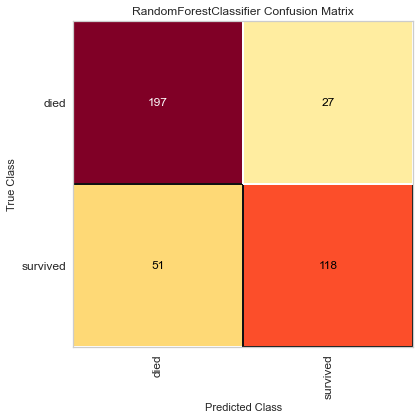

In [53]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig(
    "/Users/aline/Titanic/confusion_matrix.png",
    dpi=300,
    bbox_inches="tight",
)

## ROC Curve

A receiver operating characteristic (ROC) plot is a common tool used to evaluate classifiers. By measuring the area under the curve (AUC), we can get a metric to compare different classifiers. It plots the true positive rate against the false positive rate. We can use sklearn to calculate the AUC:

In [54]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7888445688926458

Or Yellowbrick to visualize the plot:

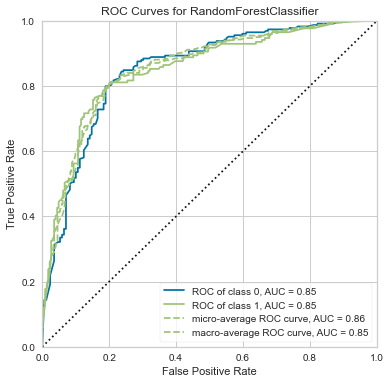

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(rf5, is_fitted=True)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)

roc_viz.poof()
fig.savefig("/Users/aline/Titanic/roc_curve.png")

## Learning Curve

A learning curve is used to tell us if we have enough training data. It trains the model with increasing portions of the data and measures the score. If the cross-validation score continues to climb, then we might need to invest in gathering more data. Here is a Yellowbrick example:

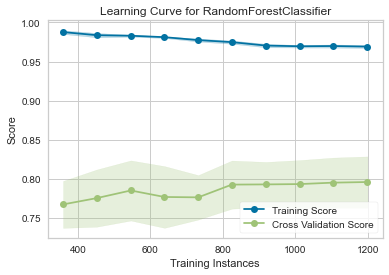

In [61]:
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf5,
    cv = cv,
    train_sizes = sizes,
    scoring = "f1_weighted",
    n_jobs = -1,
    ax = ax,
)

lc_viz.fit(X, y)
lc_viz.poof()

fig.savefig("/Users/aline/Titanic/learning_curve.png")

## Deploy Model

Using Python’s pickle module, we can persist models and load them. Once we have a model, we call the .predict method to get a classification or regression result:

In [62]:
import pickle

pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7888445688926458

In [63]:
# save the model to disk
pickle.dump(rf6, open("/Users/aline/Titanic/model.pkl", "wb"))